<a href="https://colab.research.google.com/github/vincentchowto/dissertationcodes/blob/main/DissertationCodes_Hung_To_Chow001154787.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
## Convert ICRG monthly dataset to long format
# pip install pandas openpyxl numpy
import pandas as pd
import numpy as np
from functools import reduce
from pathlib import Path
import re

# Configuration
INPUT = "ICRG_T3Ba-1.xlsx"
SHEETS = ["GovStab","SocioEcoCond","InvProf","IntConf","ExtConf"]

# Row indexes
HEADER_ROW = 5          # row 6 has country names
DATA_START_ROW = 6      # data begin on the next row (row 7)

# Output
LONG_OUT = Path("ICRG_long_format.csv")

# Selected country names
SELECTED_COUNTRIES = [
    "Australia","Italy","Belgium","Japan","Brazil","South Korea","Canada","Mexico",
    "China, Peoples' Rep.","Poland","Colombia","Russia","France","Spain","Germany","Sweden",
    "Hong Kong","United Kingdom","India","United States"
]

# Country alias map
ALIASES = {
    # Canonicals map to themselves
    **{c: c for c in SELECTED_COUNTRIES},

    # Common alternates
    "Korea, South": "South Korea",
    "Republic of Korea": "South Korea",
    "Korea (Republic of)": "South Korea",
    "S. Korea": "South Korea",

    "United States of America": "United States",
    "USA": "United States",
    "U.S.": "United States",
    "U.S.A.": "United States",

    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
    "UK": "United Kingdom",
    "U.K.": "United Kingdom",
    "Britain": "United Kingdom",

    "Russian Federation": "Russia",

    "Hong Kong SAR": "Hong Kong",
    "Hong Kong S.A.R.": "Hong Kong",

    "People's Republic of China": "China, Peoples' Rep.",
    "China": "China, Peoples' Rep.",
    "China, People's Rep.": "China, Peoples' Rep.",
}

# Helpers
def make_unique(headers):
    """Ensure duplicate header names become unique (e.g., 'Australia', 'Australia.1')."""
    seen, out = {}, []
    for h in headers:
        if h in seen:
            seen[h] += 1
            out.append(f"{h}.{seen[h]}")
        else:
            seen[h] = 0
            out.append(h)
    return out

def parse_to_month(s: pd.Series) -> pd.Series:
    """Parse a messy date column to pandas month-end timestamps."""
    # 1) standard parser
    dt = pd.to_datetime(s, errors="coerce")
    if dt.notna().mean() >= 0.8:
        return dt.dt.to_period("M").dt.to_timestamp("M")

    # 2) YYYYMM (e.g., 200304)
    s_str = s.astype(str).str.strip()
    mask_yyyymm = s_str.str.fullmatch(r"\d{6}")
    if mask_yyyymm.any():
        dt2 = pd.to_datetime(s_str.where(mask_yyyymm), format="%Y%m", errors="coerce")
        dt = dt.where(dt.notna(), dt2)
        if dt.notna().mean() >= 0.8:
            return dt.dt.to_period("M").dt.to_timestamp("M")

    # 3) Excel serial (days since 1899-12-30)
    s_num = pd.to_numeric(s, errors="coerce")
    mask_serial = s_num.between(20000, 60000) & dt.isna()
    if mask_serial.any():
        excel_dt = pd.to_datetime("1899-12-30") + pd.to_timedelta(s_num[mask_serial], unit="D")
        dt.loc[mask_serial] = excel_dt.values
        if dt.notna().mean() >= 0.8:
            return dt.dt.to_period("M").dt.to_timestamp("M")

    # 4) 2003/04, 2003-4
    mask_ym = s_str.str.match(r"^\d{4}[-/ ]?\d{1,2}$") & dt.isna()
    if mask_ym.any():
        def _ym(x):
            x = re.sub(r"[^\d]", "", x)
            if len(x) >= 5:
                y, m = int(x[:4]), int(x[4:6])
                if 1 <= m <= 12:
                    return pd.Timestamp(y, m, 1)
            return pd.NaT
        dt2 = s_str[mask_ym].map(_ym)
        dt.loc[mask_ym] = dt2.values
        if dt.notna().mean() >= 0.8:
            return dt.dt.to_period("M").dt.to_timestamp("M")

    return dt.dt.to_period("M").dt.to_timestamp("M")

def normalize_country(x: str) -> str:
    if pd.isna(x):
        return x
    x = str(x).strip()
    return ALIASES.get(x, x)

def read_sheet_to_long(fp: Path, sheet: str) -> pd.DataFrame:
    """Read one sheet, normalize headers, melt wide→long, normalize country, and deduplicate."""
    df = pd.read_excel(fp, sheet_name=sheet, engine="openpyxl", header=None)

    # Country names are on HEADER_ROW
    headers = [("Unknown" if pd.isna(h) else str(h).strip()) for h in df.iloc[HEADER_ROW].tolist()]
    headers = make_unique(headers)

    # Data start on DATA_START_ROW
    data = df.iloc[DATA_START_ROW:].copy()
    data.columns = headers
    data = data.dropna(axis=1, how="all").dropna(how="all")

    # First column is the date column; rename → Date, parse to month-end
    date_col = data.columns[0]
    data = data.rename(columns={date_col: "Date"})
    data["Date"] = parse_to_month(data["Date"])

    # Wide → Long (value_name is the indicator name = sheet)
    long_df = data.melt(id_vars=["Date"], var_name="Country_raw", value_name=sheet)
    long_df = long_df.dropna(subset=["Date", "Country_raw"])

    # Normalize country
    long_df["Country"] = long_df["Country_raw"].map(normalize_country)

    # Collapse duplicates within the sheet at (Date, Country)
    long_df = (
        long_df.groupby(["Date","Country"], as_index=False)[sheet]
               .first()  # or .mean() if you prefer to average duplicate entries
    )
    return long_df

# Build long data for each sheet, then merge on normalized keys
long_parts = [read_sheet_to_long(INPUT, s) for s in SHEETS]

# Outer-merge all indicators on (Date, Country)
long_all = reduce(lambda L, R: pd.merge(L, R, on=["Date","Country"], how="outer"), long_parts)

# Final defense: ensure one row per (Date, Country)
long_all = (
    long_all.sort_values(["Country","Date"])
            .groupby(["Date","Country"], as_index=False)
            .first()
            .reset_index(drop=True)
)

# Save long-format file
long_all.to_csv(LONG_OUT, index=False)
print(f"Saved long-format file → {LONG_OUT.resolve()}")
print("Rows:", len(long_all))
print("Date coverage:", long_all["Date"].min(), "→", long_all["Date"].max())
print("Example head:\n", long_all.head(10))


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Saved long-format file → /content/ICRG_long_format.csv
Rows: 38160
Date coverage: 2001-05-31 00:00:00 → 2023-05-31 00:00:00
Example head:
         Date     Country GovStab SocioEcoCond InvProf IntConf ExtConf
0 2001-05-31     Albania       3            1     2.5       3       3
1 2001-05-31     Algeria     2.5            0     2.5       2     3.5
2 2001-05-31      Angola       4            2       3       0       2
3 2001-05-31   Argentina       3          1.5     3.5       4       4
4 2001-05-31     Armenia       3            2     2.5       3     2.5
5 2001-05-31   Australia     3.5          2.5       3       4       4
6 2001-05-31     Austria     2.5          2.5       4       4       4
7 2001-05-31  Azerbaijan     3.5          2.5     2.5       3     2.5
8 2001-05-31     Bahamas       4            3       4       4       4
9 2001-05-31     Bahrain       4          2.5       4       4       4


In [3]:
## Keep selected countries and calculate aggregated monthly ICRG risk indicators
# pip install pandas
import pandas as pd
import numpy as np

# Inputs / Outputs
INPUT_LONG = "ICRG_long_format.csv"
CM_AVG_OUT      = "ICRG_monthly_by_country_selected.csv"
AGG_MONTHLY_OUT = "ICRG_monthly_aggregated_selected.csv"

# Selected country names
SELECTED_COUNTRIES = [
    "Australia","Italy","Belgium","Japan","Brazil","South Korea","Canada","Mexico",
    "China","Poland","Colombia","Russia","France","Spain","Germany","Sweden",
    "Hong Kong","United Kingdom","India","United States"
]

# Map common variants to your exact spellings above
ALIASES_TO_SELECTED = {
    "China, Peoples' Rep.": "China",
    "China, People's Rep.": "China",
    "China,": "China",
    "China": "China",   # explicit pass-through
}

# Load & prepare
df = pd.read_csv(INPUT_LONG)

# Ensure Date → month-end timestamps
df["Date"] = pd.to_datetime(df["Date"], errors="coerce").dt.to_period("M").dt.to_timestamp("M")

# Normalize country names
def norm_country(x):
    if pd.isna(x):
        return x
    x = str(x).strip()
    return ALIASES_TO_SELECTED.get(x, x)

df["Country"] = df["Country"].map(norm_country)

# Filter to selected countries AND date window
mask_c = df["Country"].isin(SELECTED_COUNTRIES)
mask_t = (df["Date"] >= "2003-04-01") & (df["Date"] <= "2023-01-31")
df_sel = df[mask_c & mask_t].copy()

# Identify indicator columns
expected = {"GovStab","SocioEcoCond","InvProf","IntConf","ExtConf"}
indicators = [c for c in df_sel.columns if c in expected]

# Coerce indicators to numeric
for c in indicators:
    df_sel[c] = pd.to_numeric(df_sel[c], errors="coerce")

# Monthly averages by country
cm_avg = (
    df_sel.groupby(["Date","Country"], as_index=False)[indicators]
          .mean()
          .sort_values(["Country","Date"])
          .reset_index(drop=True)
)

# Aggregated risk indicators (per-country, per-month)
# Simple equal-weight composite
cm_avg["AllIndicators_Mean"] = cm_avg[indicators].mean(axis=1)

# Z-score composite (standardise each indicator within the filtered window before averaging)
z_scored = cm_avg.copy()
for col in indicators:
    mu = cm_avg[col].mean(skipna=True)
    sd = cm_avg[col].std(ddof=0, skipna=True)
    z_scored[col] = (cm_avg[col] - mu) / sd if sd and not np.isnan(sd) and sd != 0 else np.nan
cm_avg["Composite_ZScore"] = z_scored[indicators].mean(axis=1)

# Min–max 0–100 composite (scale each indicator to 0–100 within the filtered window, then average)
mm_scaled = cm_avg.copy()
for col in indicators:
    vmin = cm_avg[col].min(skipna=True)
    vmax = cm_avg[col].max(skipna=True)
    if pd.notna(vmin) and pd.notna(vmax) and vmax != vmin:
        mm_scaled[col] = (cm_avg[col] - vmin) / (vmax - vmin) * 100.0
    else:
        mm_scaled[col] = np.nan
cm_avg["Composite_MinMax_0_100"] = mm_scaled[indicators].mean(axis=1)

# Save per-country monthly output
cm_avg.to_csv(CM_AVG_OUT, index=False)

# Cross-country monthly aggregates
agg_cols = indicators + ["AllIndicators_Mean", "Composite_ZScore", "Composite_MinMax_0_100"]
monthly_agg = (
    cm_avg.groupby("Date", as_index=False)[agg_cols]
          .mean()
          .sort_values("Date")
          .reset_index(drop=True)
)

monthly_agg.to_csv(AGG_MONTHLY_OUT, index=False)

# Friendly summary
print(f"Saved: {CM_AVG_OUT}")
print(f"Saved: {AGG_MONTHLY_OUT}")
print(f"Countries included: {sorted(cm_avg['Country'].unique().tolist())}")
print(f"Date coverage: {cm_avg['Date'].min()} → {cm_avg['Date'].max()}")
print(f"Rows (monthly by country): {len(cm_avg)}, Rows (monthly aggregate): {len(monthly_agg)}")



Saved: ICRG_monthly_by_country_selected.csv
Saved: ICRG_monthly_aggregated_selected.csv
Countries included: ['Australia', 'Belgium', 'Brazil', 'Canada', 'China', 'Colombia', 'France', 'Germany', 'Hong Kong', 'India', 'Italy', 'Japan', 'Mexico', 'Poland', 'Russia', 'South Korea', 'Spain', 'Sweden', 'United Kingdom', 'United States']
Date coverage: 2003-04-30 00:00:00 → 2023-01-31 00:00:00
Rows (monthly by country): 4760, Rows (monthly aggregate): 238


In [5]:
## HMM model selection by BIC
import numpy as np
import pandas as pd

# Utility functions
def _normalize(arr):
    arr = np.asarray(arr, dtype=float)
    lo, hi = np.min(arr), np.max(arr)
    if hi == lo:
        return np.zeros_like(arr)
    return (arr - lo) / (hi - lo)

def kneedle_elbow(K_vals, bic_vals):
    K = np.asarray(K_vals, dtype=float)
    B = np.asarray(bic_vals, dtype=float)
    order = np.argsort(K)
    K = K[order]; B = B[order]
    x = _normalize(K)
    y = _normalize(B)
    y_up = 1.0 - y
    g = y_up - x
    idx = int(np.argmax(g))
    return int(K[idx])

def delta_rule_elbow(K_vals, bic_vals, tau=0.05):
    K = np.asarray(K_vals, dtype=int)
    B = np.asarray(bic_vals, dtype=float)
    order = np.argsort(K)
    K = K[order]; B = B[order]

    total_imp = B[0] - B[-1]
    if total_imp <= 0 or len(K) < 3:
        return int(K[np.argmin(B)])

    for i in range(1, len(K)):
        step_imp = B[i-1] - B[i]
        if step_imp / total_imp < tau:
            return int(K[i-1])

    step_imps = (B[:-1] - B[1:])
    i_star = int(np.argmax(step_imps))
    return int(K[i_star])

def choose_with_tolerance(df, bic_col="BIC_Median", tol=10.0, prefer=3):
    sub = df.sort_values("K")
    K = sub["K"].to_numpy()
    B = sub[bic_col].to_numpy()
    k_min = int(K[np.argmin(B)])
    bic_min = np.min(B)
    if prefer in set(K):
        bic_pref = float(sub.loc[sub["K"] == prefer, bic_col])
        if (bic_pref - bic_min) <= tol:
            return prefer
    return k_min

# Debug + final recommendation
def debug_elbow(df, bic_col="BIC_Median", tau=0.05, prefer_parsimony=True, tol=None):
    sub = df.sort_values("K")
    K = sub["K"].to_numpy()
    B = sub[bic_col].to_numpy()

    # Step improvements
    dB = np.r_[np.nan, B[:-1] - B[1:]]

    # Pretty table
    table = pd.DataFrame({
        "K": K,
        "BIC": B,
        "ΔBIC_from_prev": dB
    })
    print("BIC by K")
    print(table.to_string(index=False))
    print(f"\nTotal improvement (K={K[0]} → K={K[-1]}): {B[0]-B[-1]:.3f}")

    # Individual picks
    k_minbic = int(K[np.argmin(B)])
    k_kneedle = kneedle_elbow(K, B)
    k_delta = delta_rule_elbow(K, B, tau=tau)

    print("\n Elbow rule picks")
    print(f"   BIC_min            : {k_minbic}")
    print(f"   Kneedle            : {k_kneedle}")
    print(f"   DeltaRule(τ={tau:.0%}) : {k_delta}")

    # Majority vote
    votes = [k_minbic, k_kneedle, k_delta]
    counts = pd.Series(votes).value_counts()
    top_ks = counts[counts == counts.max()].index.tolist()
    if prefer_parsimony:
        k_rec = min(top_ks)
    else:
        k_rec = top_ks[0]

    # Apply tolerance override if specified
    if tol is not None:
        k_tol = choose_with_tolerance(df, bic_col=bic_col, tol=tol, prefer=3)
        if k_tol != k_rec:
            print(f"\nTolerance rule applied: K=3 is within ΔBIC ≤ {tol}, overriding vote.")
            k_rec = k_tol

    print("\n Final Recommendation")
    print(f"   Recommended K = {k_rec}")
    return k_rec

# Example fake data (replace with your bic_df!)
bic_df = pd.DataFrame({
    "K": [2, 3, 4, 5],
    "BIC_Median": [-10500.32, -17890.44, -25110.78, -33650.22]
})

k_star = debug_elbow(bic_df, bic_col="BIC_Median", tau=0.05, prefer_parsimony=True, tol=50)


BIC by K
 K       BIC  ΔBIC_from_prev
 2 -10500.32             NaN
 3 -17890.44         7390.12
 4 -25110.78         7220.34
 5 -33650.22         8539.44

Total improvement (K=2 → K=5): 23149.900

 Elbow rule picks
   BIC_min            : 5
   Kneedle            : 2
   DeltaRule(τ=5%) : 4

Tolerance rule applied: K=3 is within ΔBIC ≤ 50, overriding vote.

 Final Recommendation
   Recommended K = 5


/tmp/ipython-input-3058292650.py:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  bic_pref = float(sub.loc[sub["K"] == prefer, bic_col])


In [15]:
## ICRG HMM (hmmlearn version) — per-country 1D Gaussian HMM with regime plots and segments CSV
#! pip install hmmlearn
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

# Configuration
ICRG_CSV     = "ICRG_monthly_by_country_selected.csv"
OUT_SEG_CSV  = "icrg_hmm_segments.csv"
OUT_PLOT_DIR = Path("icrg_hmm_plots")

N_STATES       = 3       # number of hidden regimes
MIN_MONTHS     = 24      # skip countries with fewer months
MAX_ITERS      = 150
TOL            = 1e-4
SMOOTH_WINDOW  = 1       # odd integer; 1 disables smoothing
RANDOM_STATE   = 123

# If composite isn’t present, we’ll build it from these if available
INDICATOR_COLS = ["AllIndicators_Mean","GovStab","SocioEcoCond","InvProf","IntConf","ExtConf"]

# Colors to match your attachment (state backgrounds + change lines)
STATE_FILL = {
    1: "#FFEAEA",  # State 1 = high risk → light red
    2: "#EAF4FF",  # State 2 = mid risk  → pale blue
    3: "#E8F7E8",  # State 3 = low risk  → pale green
}
CHANGE_LINE_COLOR = "#D62728"  # dashed vertical lines at regime changes (red)

# Utilities
def median_smooth_states(states: np.ndarray, k: int) -> np.ndarray:
    if k <= 1 or k % 2 == 0:
        return states
    pad = k // 2
    s = np.pad(states, (pad, pad), mode="edge")
    out = np.copy(states)
    for i in range(len(states)):
        out[i] = int(np.median(s[i:i+k]))
    return out

def compress_states(dates: pd.Series, states: np.ndarray):
    segs = []
    if len(states) == 0:
        return segs
    start = 0
    for i in range(1, len(states)):
        if states[i] != states[i-1]:
            segs.append((dates.iloc[start], dates.iloc[i-1], int(states[i-1])))
            start = i
    segs.append((dates.iloc[start], dates.iloc[-1], int(states[-1])))
    return segs

def plot_country(country: str, df_c: pd.DataFrame, states: np.ndarray, outdir: Path):
    dates = df_c["Date"].reset_index(drop=True)
    y     = df_c["ICRG_composite"].reset_index(drop=True)

    segs = compress_states(dates, states)
    change_points = [s[1] for s in segs[:-1]]

    fig, ax = plt.subplots(figsize=(11, 3.6))

    # Background fills by state (light tints)
    for (start, end, st) in segs:
        color = STATE_FILL.get(int(st), "#F5F5F5")
        ax.axvspan(start, end, facecolor=color, alpha=1.0, zorder=0)

    # Composite line (black), on top of fills
    ax.plot(dates, y, color="black", linewidth=1.6, label="ICRG composite", zorder=2)

    # Red dashed vertical lines at change points
    for cp in change_points:
        ax.axvline(cp, color=CHANGE_LINE_COLOR, linestyle="--", linewidth=1.0, alpha=0.9, zorder=3)

    ax.set_title(f"HMM Regimes • {country}")
    ax.set_xlabel("Time")
    ax.set_ylabel("ICRG composite")
    ax.legend(loc="upper left", frameon=False)
    ax.set_facecolor("white")
    for spine in ax.spines.values():
        spine.set_alpha(0.6)

    fig.tight_layout()
    outdir.mkdir(parents=True, exist_ok=True)
    fig.savefig(outdir / f"{country}_hmm.png", dpi=180)
    plt.close(fig)

# Load & prepare data
df = pd.read_csv(ICRG_CSV)

if "Date" not in df.columns or "Country" not in df.columns:
    raise ValueError("Input must contain 'Date' and 'Country' columns.")

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).copy()

# Build composite if needed
if "ICRG_composite" not in df.columns:
    present = [c for c in INDICATOR_COLS if c in df.columns]
    if not present:
        raise ValueError("No 'ICRG_composite' and no ICRG indicator columns found.")
    for c in present:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    if "AllIndicators_Mean" in present:
        df["ICRG_composite"] = df["AllIndicators_Mean"]
    else:
        df["ICRG_composite"] = df[[c for c in present if c != "AllIndicators_Mean"]].mean(axis=1)

df["ICRG_composite"] = pd.to_numeric(df["ICRG_composite"], errors="coerce")
df = df.dropna(subset=["ICRG_composite"])
df = df.sort_values(["Country","Date"]).reset_index(drop=True)

# Fit per-country with hmmlearn
rows = []
for country, g in df.groupby("Country"):
    g = g.sort_values("Date").reset_index(drop=True)
    if len(g) < MIN_MONTHS:
        continue

    X = g["ICRG_composite"].astype(float).values.reshape(-1, 1)

    # Gaussian HMM (1D), diagonal covariance; let hmmlearn handle EM/FB/Viterbi
    model = GaussianHMM(
        n_components=N_STATES,
        covariance_type="diag",
        n_iter=MAX_ITERS,
        tol=TOL,
        random_state=RANDOM_STATE,
        verbose=False,
    )

    # Fit and decode
    model.fit(X)
    # Most likely state at each time via Viterbi:
    states0 = model.predict(X)  # 0..K-1

    # Order states by mean to map (1=lowest mean risk, 3=highest mean or vice versa)
    means = model.means_.ravel()          # shape (K,)
    order = np.argsort(means)             # ascending by mean
    rank_map = {orig: r+1 for r, orig in enumerate(order)}  # 1..K
    states = np.array([rank_map[s] for s in states0], dtype=int)

    # Optional median smoothing for cosmetic stability
    states = median_smooth_states(states, SMOOTH_WINDOW)

    # Plot
    plot_country(country, g, states, OUT_PLOT_DIR)

    # Segments per contiguous regime
    for (start, end, st) in compress_states(g["Date"], states):
        months = (end.to_period("M") - start.to_period("M")).n + 1
        mask = (g["Date"] >= start) & (g["Date"] <= end)
        rows.append({
            "Country": country,
            "State": int(st),
            "Start": start.date(),
            "End": end.date(),
            "Months": int(months),
            "ICRG_mean": float(g.loc[mask, "ICRG_composite"].mean()),
        })

# Save outputs
seg_df = pd.DataFrame(rows).sort_values(["Country","Start"])
seg_df.to_csv(OUT_SEG_CSV, index=False)
print(f"Saved segments → {OUT_SEG_CSV}")
print(f"Saved plots in → {OUT_PLOT_DIR.resolve()}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 3.6 MB/s eta 0:00:00


Saved segments → icrg_hmm_segments.csv
Saved plots in → /content/icrg_hmm_plots


In [14]:
## Hand-coded HMM on ICRG monthly indicators (multi-country) for appendix
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Configuration
ICRG_CSV     = "ICRG_monthly_by_country_selected.csv"
OUT_SEG_CSV  = "icrg_hmm_segments.csv"
OUT_PLOT_DIR = Path("icrg_hmm_plots")

N_STATES       = 3      # number of hidden regimes
MIN_MONTHS     = 24     # skip countries with fewer months
MAX_ITERS      = 150
TOL            = 1e-4
VAR_FLOOR      = 1e-6
SMOOTH_WINDOW  = 1

# If composite isn’t present, we’ll build it from these if available
INDICATOR_COLS = ["AllIndicators_Mean","GovStab","SocioEcoCond","InvProf","IntConf","ExtConf"]

# Colors to match the attachment (state backgrounds + change lines)
STATE_FILL = {
    1: "#FFEAEA",  # State 1 = high risk → light red
    2: "#EAF4FF",  # State 2 = mid risk  → pale blue
    3: "#E8F7E8",  # State 3 = low risk  → pale green
}
CHANGE_LINE_COLOR = "#D62728"  # dashed vertical lines at regime changes (red)

# Small utilities
def median_smooth_states(states: np.ndarray, k: int) -> np.ndarray:
    if k <= 1 or k % 2 == 0:
        return states
    pad = k // 2
    s = np.pad(states, (pad, pad), mode="edge")
    out = np.copy(states)
    for i in range(len(states)):
        out[i] = int(np.median(s[i:i+k]))
    return out

def logsumexp(a, axis=None, keepdims=False):
    a = np.asarray(a)
    m = np.max(a, axis=axis, keepdims=True)
    out = m + np.log(np.sum(np.exp(a - m), axis=axis, keepdims=True))
    if not keepdims:
        out = np.squeeze(out, axis=axis)
    return out

def gaussian_logpdf_1d(x, mean, var):
    var = np.maximum(var, VAR_FLOOR)
    logdet = 0.5 * np.log(2.0 * np.pi * var)
    diffsq = (x[:, None] - mean[None, :])**2
    return -logdet[None, :] - 0.5 * diffsq / var[None, :]

def forward_backward_log(pi, A, logB):
    T, K = logB.shape
    logpi = np.log(pi + 1e-16)
    logA  = np.log(A  + 1e-16)

    # forward
    log_alpha = np.zeros((T, K))
    log_alpha[0] = logpi + logB[0]
    for t in range(1, T):
        log_alpha[t] = logB[t] + logsumexp(log_alpha[t-1][:, None] + logA, axis=0)

    # backward
    log_beta = np.zeros((T, K))
    for t in range(T-2, -1, -1):
        log_beta[t] = logsumexp(logA + logB[t+1][None, :] + log_beta[t+1][None, :], axis=1)

    ll = logsumexp(log_alpha[-1])

    # posteriors
    log_gamma = log_alpha + log_beta
    log_gamma -= logsumexp(log_gamma, axis=1, keepdims=True)
    gamma = np.exp(log_gamma)

    xi = np.zeros((T-1, K, K))
    for t in range(T-1):
        m = log_alpha[t][:, None] + logA + logB[t+1][None, :] + log_beta[t+1][None, :]
        m -= logsumexp(m)
        xi[t] = np.exp(m)
    return gamma, xi, ll

def viterbi_decode(pi, A, logB):
    T, K = logB.shape
    logpi = np.log(pi + 1e-16)
    logA  = np.log(A  + 1e-16)
    delta = np.zeros((T, K))
    psi   = np.zeros((T, K), dtype=int)
    delta[0] = logpi + logB[0]
    for t in range(1, T):
        tmp = delta[t-1][:, None] + logA
        psi[t] = np.argmax(tmp, axis=0)
        delta[t] = np.max(tmp, axis=0) + logB[t]
    states = np.zeros(T, dtype=int)
    states[-1] = np.argmax(delta[-1])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states

def kmeans_1d_init(x, K, rng):
    centers = np.percentile(x, np.linspace(0, 100, K+2)[1:-1])
    centers = np.asarray(centers, dtype=float)
    for _ in range(20):
        d = np.abs(x[:, None] - centers[None, :])
        labels = d.argmin(axis=1)
        for k in range(K):
            if np.any(labels == k):
                centers[k] = x[labels == k].mean()
            else:
                centers[k] = x[rng.integers(0, len(x))]
    labels = np.abs(x[:, None] - centers[None, :]).argmin(axis=1)
    means = centers
    vars_ = np.array([np.var(x[labels == k]) if np.any(labels == k) else np.var(x) for k in range(K)]) + 1e-3
    return means, vars_

def fit_hmm_gaussian_1d(x, K=3, max_iters=100, tol=1e-4, seed=42):
    rng = np.random.default_rng(seed)
    means, vars_ = kmeans_1d_init(x, K, rng)
    pi = np.ones(K) / K
    A  = np.ones((K, K))
    A  = A / A.sum(axis=1, keepdims=True)

    prev_ll = -np.inf
    for _ in range(max_iters):
        logB = gaussian_logpdf_1d(x, means, vars_)
        gamma, xi, ll = forward_backward_log(pi, A, logB)

        # M-step
        pi = gamma[0] + 1e-16
        pi = pi / pi.sum()

        A = xi.sum(axis=0) + 1e-16
        A = A / A.sum(axis=1, keepdims=True)

        w = gamma.sum(axis=0) + 1e-16
        means = (gamma * x[:, None]).sum(axis=0) / w
        diff2 = (x[:, None] - means[None, :])**2
        vars_ = (gamma * diff2).sum(axis=0) / w
        vars_ = np.maximum(vars_, VAR_FLOOR)

        if abs(ll - prev_ll) < tol:
            break
        prev_ll = ll

    # Viterbi decode
    logB = gaussian_logpdf_1d(x, means, vars_)
    states = viterbi_decode(pi, A, logB)
    return {"pi": pi, "A": A, "means": means, "vars": vars_, "states": states, "loglike": prev_ll}

def compress_states(dates: pd.Series, states: np.ndarray):
    segs = []
    if len(states) == 0:
        return segs
    start = 0
    for i in range(1, len(states)):
        if states[i] != states[i-1]:
            segs.append((dates.iloc[start], dates.iloc[i-1], int(states[i-1])))
            start = i
    segs.append((dates.iloc[start], dates.iloc[-1], int(states[-1])))
    return segs

def plot_country(country: str, df_c: pd.DataFrame, states: np.ndarray, outdir: Path):
    """
    Plot ICRG composite with HMM regime background fills and dashed red
    vertical lines at regime changes (to match the provided example).
    """
    dates = df_c["Date"].reset_index(drop=True)
    y     = df_c["ICRG_composite"].reset_index(drop=True)

    # Build contiguous segments of constant state
    segs = compress_states(dates, states)
    change_points = [s[1] for s in segs[:-1]]  # end of each segment (i.e., state-change month)

    fig, ax = plt.subplots(figsize=(11, 3.6))

    # Background fills by state (light tints)
    for (start, end, st) in segs:
        color = STATE_FILL.get(int(st), "#F5F5F5")
        ax.axvspan(start, end, facecolor=color, alpha=1.0, zorder=0)

    # The ICRG composite line (black, on top of fills)
    ax.plot(dates, y, color="black", linewidth=1.6, label="ICRG composite", zorder=2)

    # Red dashed vertical lines at change points
    for cp in change_points:
        ax.axvline(cp, color=CHANGE_LINE_COLOR, linestyle="--", linewidth=1.0, alpha=0.9, zorder=3)

    # Styling to resemble the attachment
    ax.set_title(f"HMM Regimes • {country}")
    ax.set_xlabel("Time")
    ax.set_ylabel("ICRG composite")
    ax.legend(loc="upper left", frameon=False)

    # Keep fills bright but not overpowering
    ax.set_facecolor("white")
    for spine in ax.spines.values():
        spine.set_alpha(0.6)

    fig.tight_layout()
    outdir.mkdir(parents=True, exist_ok=True)
    fig.savefig(outdir / f"{country}_hmm.png", dpi=180)
    plt.close(fig)

# Load & prepare data
df = pd.read_csv(ICRG_CSV)

# Require multi-country columns
if "Date" not in df.columns or "Country" not in df.columns:
    raise ValueError("Input must contain 'Date' and 'Country' columns.")

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).copy()

# Build composite if needed
if "ICRG_composite" not in df.columns:
    present = [c for c in INDICATOR_COLS if c in df.columns]
    if not present:
        raise ValueError("No 'ICRG_composite' and no ICRG indicator columns found.")
    for c in present:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    if "AllIndicators_Mean" in present:
        df["ICRG_composite"] = df["AllIndicators_Mean"]
    else:
        df["ICRG_composite"] = df[[c for c in present if c != "AllIndicators_Mean"]].mean(axis=1)

df["ICRG_composite"] = pd.to_numeric(df["ICRG_composite"], errors="coerce")
df = df.dropna(subset=["ICRG_composite"])
df = df.sort_values(["Country","Date"]).reset_index(drop=True)

# Fit per-country, save segments & plots
rows = []
for country, g in df.groupby("Country"):
    g = g.sort_values("Date").reset_index(drop=True)
    if len(g) < MIN_MONTHS:
        continue

    x = g["ICRG_composite"].astype(float).values
    res = fit_hmm_gaussian_1d(x, K=N_STATES, max_iters=MAX_ITERS, tol=TOL, seed=123)

    # Order states by mean (1=lowest → K=highest) and optionally smooth
    order = np.argsort(res["means"])
    rank_map = {orig: r+1 for r, orig in enumerate(order)}
    ordered = np.array([rank_map[s] for s in res["states"]], dtype=int)
    states  = median_smooth_states(ordered, SMOOTH_WINDOW)

    # Plot
    plot_country(country, g, states, OUT_PLOT_DIR)

    # Segments per contiguous regime
    for (start, end, st) in compress_states(g["Date"], states):
        months = (end.to_period("M") - start.to_period("M")).n + 1
        mask = (g["Date"] >= start) & (g["Date"] <= end)
        rows.append({
            "Country": country,
            "State": int(st),
            "Start": start.date(),
            "End": end.date(),
            "Months": int(months),
            "ICRG_mean": float(g.loc[mask, "ICRG_composite"].mean()),
        })

# Save segments CSV and finish
seg_df = pd.DataFrame(rows).sort_values(["Country","Start"])
seg_df.to_csv(OUT_SEG_CSV, index=False)
print(f"Saved segments → {OUT_SEG_CSV}")
print(f"Saved plots in → {OUT_PLOT_DIR.resolve()}")


Saved segments → icrg_hmm_segments.csv
Saved plots in → /content/icrg_hmm_plots


In [1]:
## HMM on ICRG monthly indicators for regime detection
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Configuration
ICRG_CSV     = "ICRG_monthly_aggregated_selected.csv"
OUT_SEG_CSV  = "icrg_hmm_segments.csv"
OUT_PLOT_DIR = Path("icrg_hmm_plots")

N_STATES       = 3      # number of hidden regimes
MIN_MONTHS     = 24     # skip countries with fewer months
MAX_ITERS      = 150
TOL            = 1e-4
VAR_FLOOR      = 1e-6
SMOOTH_WINDOW  = 1

INDICATOR_COLS = ["GovStab","SocioEcoCond","InvProf","IntConf","ExtConf"]

# Small utilities
def median_smooth_states(states: np.ndarray, k: int) -> np.ndarray:
    if k <= 1 or k % 2 == 0:
        return states
    pad = k // 2
    s = np.pad(states, (pad, pad), mode="edge")
    out = np.copy(states)
    for i in range(len(states)):
        out[i] = int(np.median(s[i:i+k]))
    return out

def logsumexp(a, axis=None, keepdims=False):
    a = np.asarray(a)
    m = np.max(a, axis=axis, keepdims=True)
    out = m + np.log(np.sum(np.exp(a - m), axis=axis, keepdims=True))
    if not keepdims:
        out = np.squeeze(out, axis=axis)
    return out

def gaussian_logpdf_1d(x, mean, var):
    # x: (T,), mean/var: (K,)
    var = np.maximum(var, VAR_FLOOR)
    logdet = 0.5 * np.log(2.0 * np.pi * var)
    diffsq = (x[:, None] - mean[None, :])**2
    return -logdet[None, :] - 0.5 * diffsq / var[None, :]

def forward_backward_log(pi, A, logB):
    T, K = logB.shape
    logpi = np.log(pi + 1e-16)
    logA  = np.log(A  + 1e-16)

    # forward
    log_alpha = np.zeros((T, K))
    log_alpha[0] = logpi + logB[0]
    for t in range(1, T):
        log_alpha[t] = logB[t] + logsumexp(log_alpha[t-1][:, None] + logA, axis=0)

    # backward
    log_beta = np.zeros((T, K))
    for t in range(T-2, -1, -1):
        log_beta[t] = logsumexp(logA + logB[t+1][None, :] + log_beta[t+1][None, :], axis=1)

    ll = logsumexp(log_alpha[-1])

    # posteriors
    log_gamma = log_alpha + log_beta
    log_gamma -= logsumexp(log_gamma, axis=1, keepdims=True)
    gamma = np.exp(log_gamma)

    xi = np.zeros((T-1, K, K))
    for t in range(T-1):
        m = log_alpha[t][:, None] + logA + logB[t+1][None, :] + log_beta[t+1][None, :]
        m -= logsumexp(m)
        xi[t] = np.exp(m)
    return gamma, xi, ll

def viterbi_decode(pi, A, logB):
    T, K = logB.shape
    logpi = np.log(pi + 1e-16)
    logA  = np.log(A  + 1e-16)
    delta = np.zeros((T, K))
    psi   = np.zeros((T, K), dtype=int)
    delta[0] = logpi + logB[0]
    for t in range(1, T):
        tmp = delta[t-1][:, None] + logA
        psi[t] = np.argmax(tmp, axis=0)
        delta[t] = np.max(tmp, axis=0) + logB[t]
    states = np.zeros(T, dtype=int)
    states[-1] = np.argmax(delta[-1])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states

def kmeans_1d_init(x, K, rng):
    centers = np.percentile(x, np.linspace(0, 100, K+2)[1:-1])
    centers = np.asarray(centers, dtype=float)
    for _ in range(20):
        d = np.abs(x[:, None] - centers[None, :])
        labels = d.argmin(axis=1)
        for k in range(K):
            if np.any(labels == k):
                centers[k] = x[labels == k].mean()
            else:
                centers[k] = x[rng.integers(0, len(x))]
    labels = np.abs(x[:, None] - centers[None, :]).argmin(axis=1)
    means = centers
    vars_ = np.array([np.var(x[labels == k]) if np.any(labels == k) else np.var(x) for k in range(K)]) + 1e-3
    return means, vars_

def fit_hmm_gaussian_1d(x, K=3, max_iters=100, tol=1e-4, seed=42):
    rng = np.random.default_rng(seed)
    T = len(x)

    # Init
    means, vars_ = kmeans_1d_init(x, K, rng)
    pi = np.ones(K) / K
    A  = np.ones((K, K))
    A  = A / A.sum(axis=1, keepdims=True)

    prev_ll = -np.inf
    for _ in range(max_iters):
        logB = gaussian_logpdf_1d(x, means, vars_)
        gamma, xi, ll = forward_backward_log(pi, A, logB)

        # M-step
        pi = gamma[0] + 1e-16
        pi = pi / pi.sum()

        A = xi.sum(axis=0) + 1e-16
        A = A / A.sum(axis=1, keepdims=True)

        w = gamma.sum(axis=0) + 1e-16
        means = (gamma * x[:, None]).sum(axis=0) / w
        diff2 = (x[:, None] - means[None, :])**2
        vars_ = (gamma * diff2).sum(axis=0) / w
        vars_ = np.maximum(vars_, VAR_FLOOR)

        if abs(ll - prev_ll) < tol:
            break
        prev_ll = ll

    # Viterbi decode
    logB = gaussian_logpdf_1d(x, means, vars_)
    states = viterbi_decode(pi, A, logB)
    return {"pi": pi, "A": A, "means": means, "vars": vars_, "states": states, "loglike": prev_ll}

def compress_states(dates: pd.Series, states: np.ndarray):
    segs = []
    if len(states) == 0:
        return segs
    start = 0
    for i in range(1, len(states)):
        if states[i] != states[i-1]:
            segs.append((dates.iloc[start], dates.iloc[i-1], int(states[i-1])))
            start = i
    segs.append((dates.iloc[start], dates.iloc[-1], int(states[-1])))
    return segs

def plot_country(country: str, df_c: pd.DataFrame, states: np.ndarray, outdir: Path):
    dates = df_c["Date"].reset_index(drop=True)
    y     = df_c["ICRG_composite"].reset_index(drop=True)
    segs  = compress_states(dates, states)
    cps   = [s[1] for s in segs[:-1]]

    fig, ax = plt.subplots(figsize=(11, 3.6))
    ax.plot(dates, y, linewidth=1.5, label="ICRG composite")
    for (start, end, st) in segs:
        if st % 2 == 1:
            ax.axvspan(start, end, alpha=0.10)   # shade odd states
    for cp in cps:
        ax.axvline(cp, linestyle="--", linewidth=1)
    ax.set_title(f"HMM Regimes • {country}")
    ax.set_xlabel("Time")
    ax.set_ylabel("ICRG composite")
    ax.legend(loc="upper left")
    fig.tight_layout()
    outdir.mkdir(parents=True, exist_ok=True)
    fig.savefig(outdir / f"{country}_hmm.png", dpi=180)
    plt.close(fig)

# Load & prepare data
df = pd.read_csv(ICRG_CSV)
if "Date" not in df.columns:
    raise ValueError("CSV must contain a 'Date' column.")

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).copy()

# If Country missing, treat as single series
if "Country" not in df.columns:
    df["Country"] = "Selected"

# Build composite if needed
if "ICRG_composite" not in df.columns:
    present = [c for c in INDICATOR_COLS if c in df.columns]
    if not present:
        raise ValueError("No 'ICRG_composite' and no ICRG indicator columns found.")
    for c in present:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["ICRG_composite"] = df[present].mean(axis=1)

df["ICRG_composite"] = pd.to_numeric(df["ICRG_composite"], errors="coerce")
df = df.dropna(subset=["ICRG_composite"])
df = df.sort_values(["Country","Date"]).reset_index(drop=True)

# Fit per-country, save segments & plots
rows = []
for country, g in df.groupby("Country"):
    g = g.sort_values("Date").reset_index(drop=True)
    if len(g) < MIN_MONTHS:
        continue

    x = g["ICRG_composite"].astype(float).values
    res = fit_hmm_gaussian_1d(x, K=N_STATES, max_iters=MAX_ITERS, tol=TOL, seed=123)

    # Order states by mean (1=lowest → K=highest) and optionally smooth
    order = np.argsort(res["means"])
    rank_map = {orig: r+1 for r, orig in enumerate(order)}
    ordered = np.array([rank_map[s] for s in res["states"]], dtype=int)
    states  = median_smooth_states(ordered, SMOOTH_WINDOW)

    # Plot
    plot_country(country, g, states, OUT_PLOT_DIR)

    # Segments
    for (start, end, st) in compress_states(g["Date"], states):
        months = (end.to_period("M") - start.to_period("M")).n + 1
        mask = (g["Date"] >= start) & (g["Date"] <= end)
        rows.append({
            "Country": country,
            "State": int(st),
            "Start": start.date(),
            "End": end.date(),
            "Months": int(months),
            "ICRG_mean": float(g.loc[mask, "ICRG_composite"].mean()),
        })

seg_df = pd.DataFrame(rows).sort_values(["Country","Start"])
seg_df.to_csv(OUT_SEG_CSV, index=False)

# Fit per-country, save segments & plots
rows = []
states_rows = []

for country, g in df.groupby("Country"):
    g = g.sort_values("Date").reset_index(drop=True)
    if len(g) < MIN_MONTHS:
        continue

    x = g["ICRG_composite"].astype(float).values
    res = fit_hmm_gaussian_1d(x, K=N_STATES, max_iters=MAX_ITERS, tol=TOL, seed=123)

    # Order states by mean (1=lowest → K=highest) and optionally smooth
    order = np.argsort(res["means"])
    rank_map = {orig: r+1 for r, orig in enumerate(order)}
    ordered = np.array([rank_map[s] for s in res["states"]], dtype=int)
    states  = median_smooth_states(ordered, SMOOTH_WINDOW)

    # Collect monthly states (for the monthly states CSV)
    # change flag: 1 if state differs from previous month
    change = np.r_[np.nan, states[1:] != states[:-1]].astype("float")
    for d, st, ch, val in zip(g["Date"], states, change, g["ICRG_composite"].values):
        states_rows.append({
            "Country": country,
            "Date": pd.to_datetime(d),
            "State": int(st),
            "Change": (float(ch) if not np.isnan(ch) else 0.0),  # first month → 0
            "ICRG_composite": float(val),
        })

    # Plot
    plot_country(country, g, states, OUT_PLOT_DIR)

    # Segments
    for (start, end, st) in compress_states(g["Date"], states):
        months = (end.to_period("M") - start.to_period("M")).n + 1
        mask = (g["Date"] >= start) & (g["Date"] <= end)
        rows.append({
            "Country": country,
            "State": int(st),
            "Start": start.date(),
            "End": end.date(),
            "Months": int(months),
            "ICRG_mean": float(g.loc[mask, "ICRG_composite"].mean()),
        })

# Save segments
seg_df = pd.DataFrame(rows).sort_values(["Country","Start"])
seg_df.to_csv(OUT_SEG_CSV, index=False)
print(f"Saved segments → {OUT_SEG_CSV}")

# Save monthly states
states_df = pd.DataFrame(states_rows).sort_values(["Country","Date"]).reset_index(drop=True)
# make sure Change is 0/1
states_df["Change"] = states_df["Change"].fillna(0.0).astype(int)
states_df.to_csv("icrg_hmm_states_monthly.csv", index=False)
print("Saved monthly states → icrg_hmm_states_monthly.csv")

# Volatility metrics
# Annual change counts & rates
ann = (
    states_df.assign(Year=lambda x: x["Date"].dt.year)
             .groupby(["Country", "Year"])
             .agg(
                 changes=("Change", "sum"),
                 months=("Change", "size"),
                 mean_state=("State", "mean"),
                 mean_icrg=("ICRG_composite", "mean"),
             )
             .reset_index()
)
ann["volatility_rate"] = ann["changes"] / ann["months"]

# Rolling 12-month change rate (per month)
def add_roll_12(group):
    g = group.sort_values("Date").copy()
    g["roll12_changes"] = g["Change"].rolling(12, min_periods=6).sum()
    g["roll12_rate"] = g["roll12_changes"] / g["Change"].rolling(12, min_periods=6).count()
    return g

roll = states_df.groupby("Country", group_keys=False).apply(add_roll_12)

# Save a compact volatility file:
#   - One tab with annual metrics
#   - One tab with monthly rolling metric (if you prefer single CSV, keep ann only)
vol_df = ann.copy()
vol_df.to_csv("icrg_hmm_state_volatility.csv", index=False)
print("Saved volatility metrics → icrg_hmm_state_volatility.csv")
roll_out = roll[["Country","Date","State","Change","roll12_rate"]].copy()
roll_out.to_csv("icrg_hmm_state_volatility_rolling12.csv", index=False)
print("Saved rolling 12m rates → icrg_hmm_state_volatility_rolling12.csv")

print(f"Saved plots in → {OUT_PLOT_DIR.resolve()}")
print(f"Saved segments → {OUT_SEG_CSV}")
print(f"Saved plots in → {OUT_PLOT_DIR.resolve()}")

# Get monthly icrg_hmm_segments.csv abd icrg_hmm_plots per country based on this input file, modift the code accordingly
OUT_SEG_CSV  = "icrg_hmm_segments.csv"
OUT_PLOT_DIR = Path("icrg_hmm_plots")

FileNotFoundError: [Errno 2] No such file or directory: 'ICRG_monthly_aggregated_selected.csv'

In [7]:
## K-means clusteirng and scatterplot and correlation heatmap of co-movement analysis
## HMM on ICRG monthly indicators for regime detection
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Configuration
ICRG_CSV     = "ICRG_monthly_aggregated_selected.csv"
OUT_SEG_CSV  = "icrg_hmm_segments.csv"
OUT_PLOT_DIR = Path("icrg_hmm_plots")

N_STATES       = 3      # number of hidden regimes
MIN_MONTHS     = 24     # skip countries with fewer months
MAX_ITERS      = 150
TOL            = 1e-4
VAR_FLOOR      = 1e-6
SMOOTH_WINDOW  = 3

INDICATOR_COLS = ["GovStab","SocioEcoCond","InvProf","IntConf","ExtConf"]

# Small utilities
def median_smooth_states(states: np.ndarray, k: int) -> np.ndarray:
    if k <= 1 or k % 2 == 0:
        return states
    pad = k // 2
    s = np.pad(states, (pad, pad), mode="edge")
    out = np.copy(states)
    for i in range(len(states)):
        out[i] = int(np.median(s[i:i+k]))
    return out

def logsumexp(a, axis=None, keepdims=False):
    a = np.asarray(a)
    m = np.max(a, axis=axis, keepdims=True)
    out = m + np.log(np.sum(np.exp(a - m), axis=axis, keepdims=True))
    if not keepdims:
        out = np.squeeze(out, axis=axis)
    return out

def gaussian_logpdf_1d(x, mean, var):
    # x: (T,), mean/var: (K,)
    var = np.maximum(var, VAR_FLOOR)
    logdet = 0.5 * np.log(2.0 * np.pi * var)
    diffsq = (x[:, None] - mean[None, :])**2
    return -logdet[None, :] - 0.5 * diffsq / var[None, :]

def forward_backward_log(pi, A, logB):
    T, K = logB.shape
    logpi = np.log(pi + 1e-16)
    logA  = np.log(A  + 1e-16)

    # forward
    log_alpha = np.zeros((T, K))
    log_alpha[0] = logpi + logB[0]
    for t in range(1, T):
        log_alpha[t] = logB[t] + logsumexp(log_alpha[t-1][:, None] + logA, axis=0)

    # backward
    log_beta = np.zeros((T, K))
    for t in range(T-2, -1, -1):
        log_beta[t] = logsumexp(logA + logB[t+1][None, :] + log_beta[t+1][None, :], axis=1)

    ll = logsumexp(log_alpha[-1])

    # posteriors
    log_gamma = log_alpha + log_beta
    log_gamma -= logsumexp(log_gamma, axis=1, keepdims=True)
    gamma = np.exp(log_gamma)

    xi = np.zeros((T-1, K, K))
    for t in range(T-1):
        m = log_alpha[t][:, None] + logA + logB[t+1][None, :] + log_beta[t+1][None, :]
        m -= logsumexp(m)
        xi[t] = np.exp(m)
    return gamma, xi, ll

def viterbi_decode(pi, A, logB):
    T, K = logB.shape
    logpi = np.log(pi + 1e-16)
    logA  = np.log(A  + 1e-16)
    delta = np.zeros((T, K))
    psi   = np.zeros((T, K), dtype=int)
    delta[0] = logpi + logB[0]
    for t in range(1, T):
        tmp = delta[t-1][:, None] + logA
        psi[t] = np.argmax(tmp, axis=0)
        delta[t] = np.max(tmp, axis=0) + logB[t]
    states = np.zeros(T, dtype=int)
    states[-1] = np.argmax(delta[-1])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states

def kmeans_1d_init(x, K, rng):
    centers = np.percentile(x, np.linspace(0, 100, K+2)[1:-1])
    centers = np.asarray(centers, dtype=float)
    for _ in range(20):
        d = np.abs(x[:, None] - centers[None, :])
        labels = d.argmin(axis=1)
        for k in range(K):
            if np.any(labels == k):
                centers[k] = x[labels == k].mean()
            else:
                centers[k] = x[rng.integers(0, len(x))]
    labels = np.abs(x[:, None] - centers[None, :]).argmin(axis=1)
    means = centers
    vars_ = np.array([np.var(x[labels == k]) if np.any(labels == k) else np.var(x) for k in range(K)]) + 1e-3
    return means, vars_

def fit_hmm_gaussian_1d(x, K=3, max_iters=100, tol=1e-4, seed=42):
    rng = np.random.default_rng(seed)
    T = len(x)

    # Init
    means, vars_ = kmeans_1d_init(x, K, rng)
    pi = np.ones(K) / K
    A  = np.ones((K, K))
    A  = A / A.sum(axis=1, keepdims=True)

    prev_ll = -np.inf
    for _ in range(max_iters):
        logB = gaussian_logpdf_1d(x, means, vars_)
        gamma, xi, ll = forward_backward_log(pi, A, logB)

        # M-step
        pi = gamma[0] + 1e-16
        pi = pi / pi.sum()

        A = xi.sum(axis=0) + 1e-16
        A = A / A.sum(axis=1, keepdims=True)

        w = gamma.sum(axis=0) + 1e-16
        means = (gamma * x[:, None]).sum(axis=0) / w
        diff2 = (x[:, None] - means[None, :])**2
        vars_ = (gamma * diff2).sum(axis=0) / w
        vars_ = np.maximum(vars_, VAR_FLOOR)

        if abs(ll - prev_ll) < tol:
            break
        prev_ll = ll

    # Viterbi decode
    logB = gaussian_logpdf_1d(x, means, vars_)
    states = viterbi_decode(pi, A, logB)
    return {"pi": pi, "A": A, "means": means, "vars": vars_, "states": states, "loglike": prev_ll}

def compress_states(dates: pd.Series, states: np.ndarray):
    segs = []
    if len(states) == 0:
        return segs
    start = 0
    for i in range(1, len(states)):
        if states[i] != states[i-1]:
            segs.append((dates.iloc[start], dates.iloc[i-1], int(states[i-1])))
            start = i
    segs.append((dates.iloc[start], dates.iloc[-1], int(states[-1])))
    return segs

def plot_country(country: str, df_c: pd.DataFrame, states: np.ndarray, outdir: Path):
    dates = df_c["Date"].reset_index(drop=True)
    y     = df_c["ICRG_composite"].reset_index(drop=True)
    segs  = compress_states(dates, states)
    cps   = [s[1] for s in segs[:-1]]

    fig, ax = plt.subplots(figsize=(11, 3.6))
    ax.plot(dates, y, linewidth=1.5, label="ICRG composite")
    for (start, end, st) in segs:
        if st % 2 == 1:
            ax.axvspan(start, end, alpha=0.10)   # shade odd states
    for cp in cps:
        ax.axvline(cp, linestyle="--", linewidth=1)
    ax.set_title(f"HMM Regimes • {country}")
    ax.set_xlabel("Time")
    ax.set_ylabel("ICRG composite")
    ax.legend(loc="upper left")
    fig.tight_layout()
    outdir.mkdir(parents=True, exist_ok=True)
    fig.savefig(outdir / f"{country}_hmm.png", dpi=180)
    plt.close(fig)

#  Load and prepare data
df = pd.read_csv(ICRG_CSV)
if "Date" not in df.columns:
    raise ValueError("CSV must contain a 'Date' column.")

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).copy()

# If Country missing, treat as single series
if "Country" not in df.columns:
    df["Country"] = "Selected"

# Build composite if needed
if "ICRG_composite" not in df.columns:
    present = [c for c in INDICATOR_COLS if c in df.columns]
    if not present:
        raise ValueError("No 'ICRG_composite' and no ICRG indicator columns found.")
    for c in present:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["ICRG_composite"] = df[present].mean(axis=1)

df["ICRG_composite"] = pd.to_numeric(df["ICRG_composite"], errors="coerce")
df = df.dropna(subset=["ICRG_composite"])
df = df.sort_values(["Country","Date"]).reset_index(drop=True)

# Fit per-country, save segments and plots
rows = []
for country, g in df.groupby("Country"):
    g = g.sort_values("Date").reset_index(drop=True)
    if len(g) < MIN_MONTHS:
        continue

    x = g["ICRG_composite"].astype(float).values
    res = fit_hmm_gaussian_1d(x, K=N_STATES, max_iters=MAX_ITERS, tol=TOL, seed=123)

    # Order states by mean (1=lowest → K=highest) and optionally smooth
    order = np.argsort(res["means"])
    rank_map = {orig: r+1 for r, orig in enumerate(order)}
    ordered = np.array([rank_map[s] for s in res["states"]], dtype=int)
    states  = median_smooth_states(ordered, SMOOTH_WINDOW)

    # Plot
    plot_country(country, g, states, OUT_PLOT_DIR)

    # Segments
    for (start, end, st) in compress_states(g["Date"], states):
        months = (end.to_period("M") - start.to_period("M")).n + 1
        mask = (g["Date"] >= start) & (g["Date"] <= end)
        rows.append({
            "Country": country,
            "State": int(st),
            "Start": start.date(),
            "End": end.date(),
            "Months": int(months),
            "ICRG_mean": float(g.loc[mask, "ICRG_composite"].mean()),
        })

seg_df = pd.DataFrame(rows).sort_values(["Country","Start"])
seg_df.to_csv(OUT_SEG_CSV, index=False)

# Fit per-country, save segments and plots
rows = []
states_rows = []

for country, g in df.groupby("Country"):
    g = g.sort_values("Date").reset_index(drop=True)
    if len(g) < MIN_MONTHS:
        continue

    x = g["ICRG_composite"].astype(float).values
    res = fit_hmm_gaussian_1d(x, K=N_STATES, max_iters=MAX_ITERS, tol=TOL, seed=123)

    # Order states by mean (1=lowest → K=highest) and optionally smooth
    order = np.argsort(res["means"])
    rank_map = {orig: r+1 for r, orig in enumerate(order)}
    ordered = np.array([rank_map[s] for s in res["states"]], dtype=int)
    states  = median_smooth_states(ordered, SMOOTH_WINDOW)

    # Collect monthly states (for the monthly states CSV)
    # Change flag: 1 if state differs from previous month
    change = np.r_[np.nan, states[1:] != states[:-1]].astype("float")
    for d, st, ch, val in zip(g["Date"], states, change, g["ICRG_composite"].values):
        states_rows.append({
            "Country": country,
            "Date": pd.to_datetime(d),
            "State": int(st),
            "Change": (float(ch) if not np.isnan(ch) else 0.0),  # first month → 0
            "ICRG_composite": float(val),
        })

    # Plot
    plot_country(country, g, states, OUT_PLOT_DIR)

    # Segments
    for (start, end, st) in compress_states(g["Date"], states):
        months = (end.to_period("M") - start.to_period("M")).n + 1
        mask = (g["Date"] >= start) & (g["Date"] <= end)
        rows.append({
            "Country": country,
            "State": int(st),
            "Start": start.date(),
            "End": end.date(),
            "Months": int(months),
            "ICRG_mean": float(g.loc[mask, "ICRG_composite"].mean()),
        })

# Save segments
seg_df = pd.DataFrame(rows).sort_values(["Country","Start"])
seg_df.to_csv(OUT_SEG_CSV, index=False)
print(f"Saved segments → {OUT_SEG_CSV}")

# Save monthly states
states_df = pd.DataFrame(states_rows).sort_values(["Country","Date"]).reset_index(drop=True)
# make sure Change is 0/1
states_df["Change"] = states_df["Change"].fillna(0.0).astype(int)
states_df.to_csv("icrg_hmm_states_monthly.csv", index=False)
print("Saved monthly states → icrg_hmm_states_monthly.csv")

# Volatility metrics
# Annual change counts & rates
ann = (
    states_df.assign(Year=lambda x: x["Date"].dt.year)
             .groupby(["Country", "Year"])
             .agg(
                 changes=("Change", "sum"),
                 months=("Change", "size"),
                 mean_state=("State", "mean"),
                 mean_icrg=("ICRG_composite", "mean"),
             )
             .reset_index()
)
ann["volatility_rate"] = ann["changes"] / ann["months"]

# Rolling 12-month change rate (per month)
def add_roll_12(group):
    g = group.sort_values("Date").copy()
    g["roll12_changes"] = g["Change"].rolling(12, min_periods=6).sum()
    g["roll12_rate"] = g["roll12_changes"] / g["Change"].rolling(12, min_periods=6).count()
    return g

roll = states_df.groupby("Country", group_keys=False).apply(add_roll_12)

# Save a compact volatility file:
#   - One tab with annual metrics
#   - One tab with monthly rolling metric (if you prefer single CSV, keep ann only)
vol_df = ann.copy()
vol_df.to_csv("icrg_hmm_state_volatility.csv", index=False)
print("Saved volatility metrics → icrg_hmm_state_volatility.csv")

# Save the monthly rolling series (CSV)
roll_out = roll[["Country","Date","State","Change","roll12_rate"]].copy()
roll_out.to_csv("icrg_hmm_state_volatility_rolling12.csv", index=False)
print("Saved rolling 12m rates → icrg_hmm_state_volatility_rolling12.csv")

print(f"Saved plots in → {OUT_PLOT_DIR.resolve()}")
print(f"Saved segments → {OUT_SEG_CSV}")
print(f"Saved plots in → {OUT_PLOT_DIR.resolve()}")

# Get monthly icrg_hmm_segments.csv abd icrg_hmm_plots per country based on this input file, modift the code accordingly
OUT_SEG_CSV  = "icrg_hmm_segments.csv"
OUT_PLOT_DIR = Path("icrg_hmm_plots")


Saved segments → icrg_hmm_segments.csv
Saved monthly states → icrg_hmm_states_monthly.csv
Saved volatility metrics → icrg_hmm_state_volatility.csv
Saved rolling 12m rates → icrg_hmm_state_volatility_rolling12.csv
Saved plots in → /content/icrg_hmm_plots
Saved segments → icrg_hmm_segments.csv
Saved plots in → /content/icrg_hmm_plots


/tmp/ipython-input-622679914.py:322: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  roll = states_df.groupby("Country", group_keys=False).apply(add_roll_12)


Saved segments → icrg_hmm_segments.csv
Saved monthly states → icrg_hmm_states_monthly.csv
Saved volatility metrics → icrg_hmm_state_volatility.csv
Saved rolling 12m rates → icrg_hmm_state_volatility_rolling12.csv
Saved plots in → /content/icrg_hmm_plots

=== Cluster → Risk mapping ===
Cluster 0: mean state=1.978 → Medium Risk
Cluster 1: mean state=1.929 → High Risk
Cluster 2: mean state=2.192 → Low Risk


/tmp/ipython-input-548355649.py:290: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(


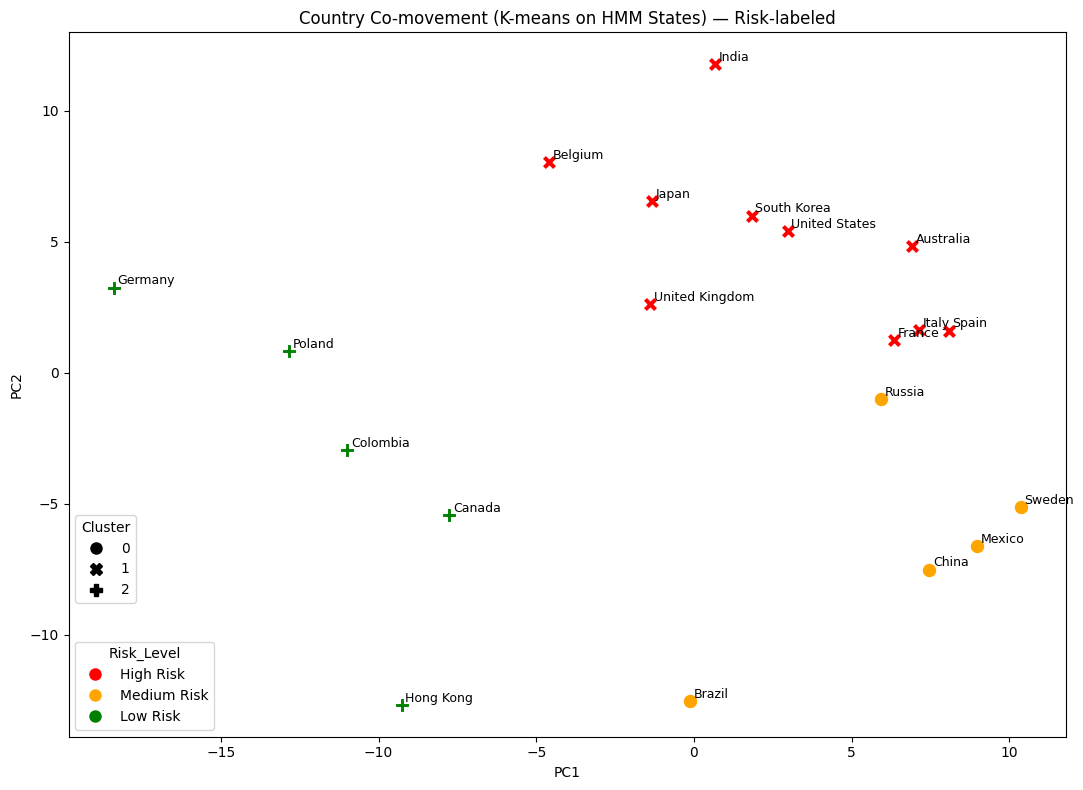

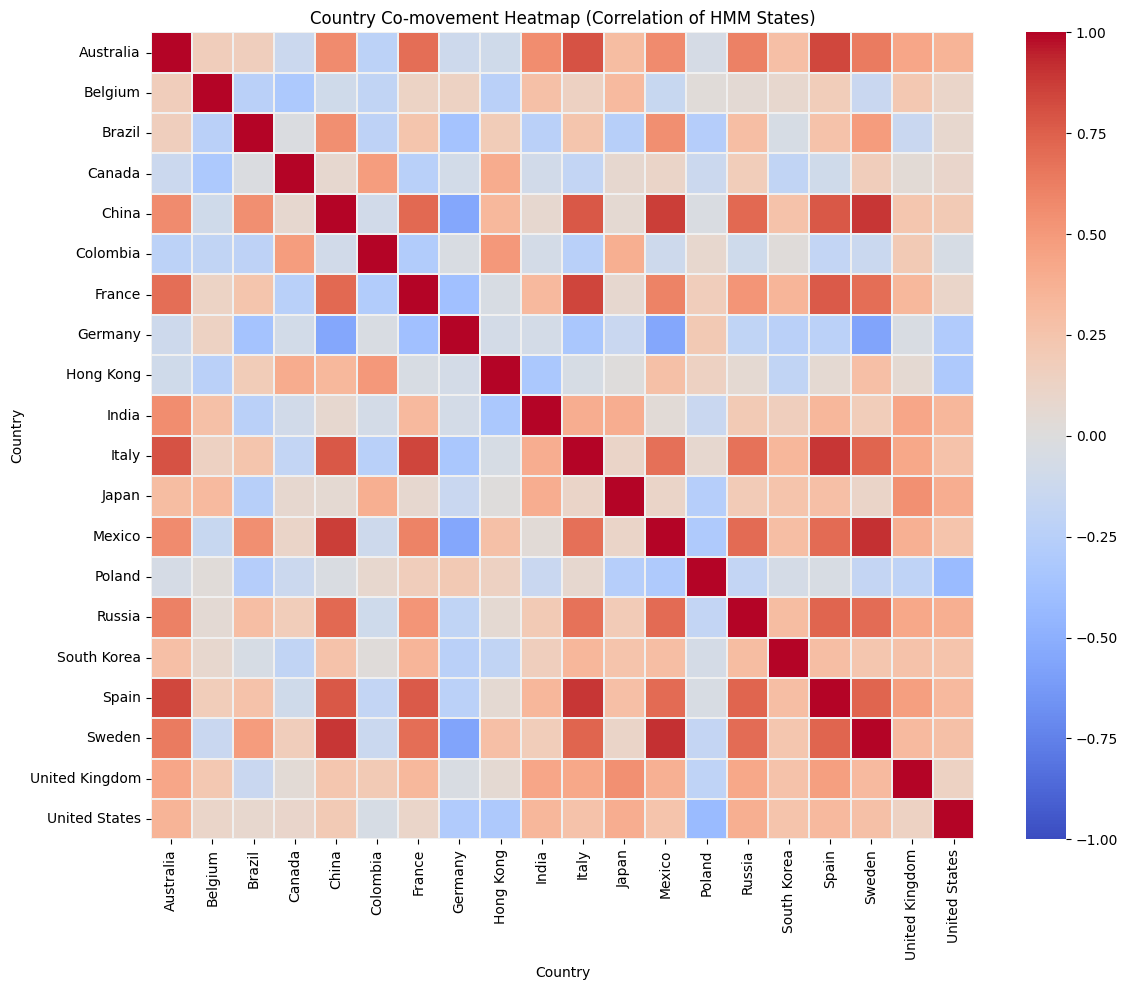


Saved:
 - icrg_hmm_states_monthly.csv
 - icrg_hmm_segments.csv
 - plots per country → /content/icrg_hmm_plots
 - icrg_hmm_state_volatility.csv
 - icrg_hmm_state_volatility_rolling12.csv
 - country_clusters_with_risk.csv
 - icrg_kmeans_scatter.png
 - icrg_kmeans_heatmap.png


In [16]:
## K-means clustering + PCA scatter + correlation heatmap (co-movement)
## HMM on ICRG monthly indicators for regime detection
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Configuration
ICRG_CSV     = "ICRG_monthly_by_country_selected.csv"
OUT_SEG_CSV  = "icrg_hmm_segments.csv"          # per-country state segments
OUT_PLOT_DIR = Path("icrg_hmm_plots")           # per-country HMM plots

N_STATES       = 3         # HMM regimes
MIN_MONTHS     = 24
MAX_ITERS      = 150
TOL            = 1e-4
VAR_FLOOR      = 1e-6
SMOOTH_WINDOW  = 3

# Co-movement / clustering configs
N_CLUSTERS     = 3        # K-means clusters across countries
SEED           = 42
POINT_SIZE     = 110

INDICATOR_COLS = ["GovStab","SocioEcoCond","InvProf","IntConf","ExtConf"]

# Small utilities
def median_smooth_states(states: np.ndarray, k: int) -> np.ndarray:
    if k <= 1 or k % 2 == 0:
        return states
    pad = k // 2
    s = np.pad(states, (pad, pad), mode="edge")
    out = np.copy(states)
    for i in range(len(states)):
        out[i] = int(np.median(s[i:i+k]))
    return out

def logsumexp(a, axis=None, keepdims=False):
    a = np.asarray(a)
    m = np.max(a, axis=axis, keepdims=True)
    out = m + np.log(np.sum(np.exp(a - m), axis=axis, keepdims=True))
    if not keepdims:
        out = np.squeeze(out, axis=axis)
    return out

def gaussian_logpdf_1d(x, mean, var):
    var = np.maximum(var, VAR_FLOOR)
    logdet = 0.5 * np.log(2.0 * np.pi * var)
    diffsq = (x[:, None] - mean[None, :])**2
    return -logdet[None, :] - 0.5 * diffsq / var[None, :]

def forward_backward_log(pi, A, logB):
    T, K = logB.shape
    logpi = np.log(pi + 1e-16)
    logA  = np.log(A  + 1e-16)

    # forward
    log_alpha = np.zeros((T, K))
    log_alpha[0] = logpi + logB[0]
    for t in range(1, T):
        log_alpha[t] = logB[t] + logsumexp(log_alpha[t-1][:, None] + logA, axis=0)

    # backward
    log_beta = np.zeros((T, K))
    for t in range(T-2, -1, -1):
        log_beta[t] = logsumexp(logA + logB[t+1][None, :] + log_beta[t+1][None, :], axis=1)

    ll = logsumexp(log_alpha[-1])

    # posteriors
    log_gamma = log_alpha + log_beta
    log_gamma -= logsumexp(log_gamma, axis=1, keepdims=True)
    gamma = np.exp(log_gamma)

    xi = np.zeros((T-1, K, K))
    for t in range(T-1):
        m = log_alpha[t][:, None] + logA + logB[t+1][None, :] + log_beta[t+1][None, :]
        m -= logsumexp(m)
        xi[t] = np.exp(m)
    return gamma, xi, ll

def viterbi_decode(pi, A, logB):
    T, K = logB.shape
    logpi = np.log(pi + 1e-16)
    logA  = np.log(A  + 1e-16)
    delta = np.zeros((T, K))
    psi   = np.zeros((T, K), dtype=int)
    delta[0] = logpi + logB[0]
    for t in range(1, T):
        tmp = delta[t-1][:, None] + logA
        psi[t] = np.argmax(tmp, axis=0)
        delta[t] = np.max(tmp, axis=0) + logB[t]
    states = np.zeros(T, dtype=int)
    states[-1] = np.argmax(delta[-1])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states

def kmeans_1d_init(x, K, rng):
    centers = np.percentile(x, np.linspace(0, 100, K+2)[1:-1])
    centers = np.asarray(centers, dtype=float)
    for _ in range(20):
        d = np.abs(x[:, None] - centers[None, :])
        labels = d.argmin(axis=1)
        for k in range(K):
            if np.any(labels == k):
                centers[k] = x[labels == k].mean()
            else:
                centers[k] = x[rng.integers(0, len(x))]
    labels = np.abs(x[:, None] - centers[None, :]).argmin(axis=1)
    means = centers
    vars_ = np.array([np.var(x[labels == k]) if np.any(labels == k) else np.var(x) for k in range(K)]) + 1e-3
    return means, vars_

def fit_hmm_gaussian_1d(x, K=3, max_iters=100, tol=1e-4, seed=42):
    rng = np.random.default_rng(seed)
    T = len(x)

    # Init
    means, vars_ = kmeans_1d_init(x, K, rng)
    pi = np.ones(K) / K
    A  = np.ones((K, K))
    A  = A / A.sum(axis=1, keepdims=True)

    prev_ll = -np.inf
    for _ in range(max_iters):
        logB = gaussian_logpdf_1d(x, means, vars_)
        gamma, xi, ll = forward_backward_log(pi, A, logB)

        # M-step
        pi = gamma[0] + 1e-16
        pi = pi / pi.sum()

        A = xi.sum(axis=0) + 1e-16
        A = A / A.sum(axis=1, keepdims=True)

        w = gamma.sum(axis=0) + 1e-16
        means = (gamma * x[:, None]).sum(axis=0) / w
        diff2 = (x[:, None] - means[None, :])**2
        vars_ = (gamma * diff2).sum(axis=0) / w
        vars_ = np.maximum(vars_, VAR_FLOOR)

        if abs(ll - prev_ll) < tol:
            break
        prev_ll = ll

    # Viterbi decode
    logB = gaussian_logpdf_1d(x, means, vars_)
    states = viterbi_decode(pi, A, logB)
    return {"pi": pi, "A": A, "means": means, "vars": vars_, "states": states, "loglike": prev_ll}

def compress_states(dates: pd.Series, states: np.ndarray):
    segs = []
    if len(states) == 0:
        return segs
    start = 0
    for i in range(1, len(states)):
        if states[i] != states[i-1]:
            segs.append((dates.iloc[start], dates.iloc[i-1], int(states[i-1])))
            start = i
    segs.append((dates.iloc[start], dates.iloc[-1], int(states[-1])))
    return segs

def plot_country(country: str, df_c: pd.DataFrame, states: np.ndarray, outdir: Path):
    dates = df_c["Date"].reset_index(drop=True)
    y     = df_c["ICRG_composite"].reset_index(drop=True)
    segs  = compress_states(dates, states)
    cps   = [s[1] for s in segs[:-1]]

    fig, ax = plt.subplots(figsize=(11, 3.6))
    ax.plot(dates, y, linewidth=1.5, label="ICRG composite")
    for (start, end, st) in segs:
        if st % 2 == 1:
            ax.axvspan(start, end, alpha=0.10)   # shade odd states
    for cp in cps:
        ax.axvline(cp, linestyle="--", linewidth=1)
    ax.set_title(f"HMM Regimes • {country}")
    ax.set_xlabel("Time")
    ax.set_ylabel("ICRG composite")
    ax.legend(loc="upper left")
    fig.tight_layout()
    outdir.mkdir(parents=True, exist_ok=True)
    fig.savefig(outdir / f"{country}_hmm.png", dpi=180)
    plt.close(fig)

# Load & prepare data
df = pd.read_csv(ICRG_CSV)
if "Date" not in df.columns:
    raise ValueError("CSV must contain a 'Date' column.")

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).copy()

# If Country missing, treat as single series
if "Country" not in df.columns:
    df["Country"] = "Selected"

# Build composite if needed
if "ICRG_composite" not in df.columns:
    present = [c for c in INDICATOR_COLS if c in df.columns]
    if not present:
        raise ValueError("No 'ICRG_composite' and no ICRG indicator columns found.")
    for c in present:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["ICRG_composite"] = df[present].mean(axis=1)

df["ICRG_composite"] = pd.to_numeric(df["ICRG_composite"], errors="coerce")
df = df.dropna(subset=["ICRG_composite"])
df = df.sort_values(["Country","Date"]).reset_index(drop=True)

# Fit per-country HMM, export segments + monthly states
rows = []
states_rows = []

for country, g in df.groupby("Country"):
    g = g.sort_values("Date").reset_index(drop=True)
    if len(g) < MIN_MONTHS:
        continue

    x = g["ICRG_composite"].astype(float).values
    res = fit_hmm_gaussian_1d(x, K=N_STATES, max_iters=MAX_ITERS, tol=TOL, seed=123)

    # Order states by mean (1=lowest → K=highest) and optionally smooth
    order = np.argsort(res["means"])
    rank_map = {orig: r+1 for r, orig in enumerate(order)}
    ordered = np.array([rank_map[s] for s in res["states"]], dtype=int)
    states  = median_smooth_states(ordered, SMOOTH_WINDOW)

    # Save monthly states
    change = np.r_[np.nan, states[1:] != states[:-1]].astype(float)
    for d, st, ch, val in zip(g["Date"], states, change, g["ICRG_composite"].values):
        states_rows.append({
            "Country": country,
            "Date": pd.to_datetime(d),
            "State": int(st),
            "Change": 0 if np.isnan(ch) else int(ch),
            "ICRG_composite": float(val),
        })

    # Plot country series with regimes
    plot_country(country, g, states, OUT_PLOT_DIR)

    # Segments table
    for (start, end, st) in compress_states(g["Date"], states):
        months = (end.to_period("M") - start.to_period("M")).n + 1
        mask = (g["Date"] >= start) & (g["Date"] <= end)
        rows.append({
            "Country": country,
            "State": int(st),
            "Start": start.date(),
            "End": end.date(),
            "Months": int(months),
            "ICRG_mean": float(g.loc[mask, "ICRG_composite"].mean()),
        })

# Save segments & monthly states
seg_df = pd.DataFrame(rows).sort_values(["Country","Start"])
seg_df.to_csv(OUT_SEG_CSV, index=False)
print(f"Saved segments → {OUT_SEG_CSV}")

states_df = pd.DataFrame(states_rows).sort_values(["Country","Date"]).reset_index(drop=True)
states_df.to_csv("icrg_hmm_states_monthly.csv", index=False)
print("Saved monthly states → icrg_hmm_states_monthly.csv")

# Volatility metrics
ann = (
    states_df.assign(Year=lambda x: x["Date"].dt.year)
             .groupby(["Country", "Year"])
             .agg(
                 changes=("Change", "sum"),
                 months=("Change", "size"),
                 mean_state=("State", "mean"),
                 mean_icrg=("ICRG_composite", "mean"),
             )
             .reset_index()
)
ann["volatility_rate"] = ann["changes"] / ann["months"]
ann.to_csv("icrg_hmm_state_volatility.csv", index=False)
print("Saved volatility metrics → icrg_hmm_state_volatility.csv")

# Rolling 12-month (optional detailed output)
roll = (
    states_df.sort_values(["Country","Date"])
             .groupby("Country", group_keys=False)
             .apply(lambda g: g.assign(
                 roll12_changes=g["Change"].rolling(12, min_periods=6).sum(),
                 roll12_rate=lambda x: x["roll12_changes"] /
                                       x["Change"].rolling(12, min_periods=6).count()
             ))
)
roll_out = roll[["Country","Date","State","Change","roll12_rate"]].copy()
roll_out.to_csv("icrg_hmm_state_volatility_rolling12.csv", index=False)
print("Saved rolling 12m rates → icrg_hmm_state_volatility_rolling12.csv")

print(f"Saved plots in → {OUT_PLOT_DIR.resolve()}")

# Co-movement across countries using HMM monthly states (K-means)
# Pivot to wide: rows=Date, cols=Country, values=State
pivot = (
    states_df.pivot(index="Date", columns="Country", values="State")
             .sort_index()
             .ffill()
             .bfill()
)

countries = pivot.columns.to_list()

# Standardize each country's state time-series across time
X = pivot.T.values                                  # shape: (n_countries, n_months)
X_scaled = StandardScaler().fit_transform(X)

# K-means clustering across countries
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=SEED, n_init=20)
labels = kmeans.fit_predict(X_scaled)

clusters = pd.DataFrame({"Country": countries, "Cluster": labels})
country_mean_state = pivot.mean(axis=0)  # average decoded state per country
clusters = clusters.merge(country_mean_state.rename("MeanState"),
                          left_on="Country", right_index=True)

# Rank clusters by MeanState (higher mean state → lower risk)
cluster_mean_by_id = clusters.groupby("Cluster")["MeanState"].mean()
ranked = cluster_mean_by_id.sort_values(ascending=False).index.tolist()

risk_map = {}
for i, cl in enumerate(ranked):
    if i == 0:
        risk_map[cl] = "Low Risk"
    elif i == len(ranked) - 1:
        risk_map[cl] = "High Risk"
    else:
        risk_map[cl] = "Medium Risk"

clusters["Risk_Level"] = clusters["Cluster"].map(risk_map)
clusters.sort_values(["Risk_Level","Cluster","Country"]).to_csv(
    "country_clusters_with_risk.csv", index=False
)

# Print the risk mapping
print("\n=== Cluster → Risk mapping ===")
for cl in sorted(cluster_mean_by_id.index):
    mean_val = cluster_mean_by_id.loc[cl]
    print(f"Cluster {cl}: mean state={mean_val:.3f} → {risk_map[cl]}")

# PCA scatter + correlation heatmap for co-movement
pca2 = PCA(n_components=2).fit(X_scaled)
coords2 = pca2.transform(X_scaled)

plt.figure(figsize=(11, 8))
palette = {"High Risk": "red", "Medium Risk": "orange", "Low Risk": "green"}
markers  = {0: "o", 1: "X", 2: "P", 3: "s", 4: "D", 5: "^"}

for i, c in enumerate(countries):
    rl = clusters.loc[clusters["Country"] == c, "Risk_Level"].iloc[0]
    cl = int(clusters.loc[clusters["Country"] == c, "Cluster"].iloc[0])
    plt.scatter(coords2[i,0], coords2[i,1],
                c=palette.get(rl, "gray"),
                marker=markers.get(cl, "o"),
                s=POINT_SIZE, edgecolor="white", linewidth=0.8)
    plt.text(coords2[i,0]+0.12, coords2[i,1]+0.12, c, fontsize=9)

plt.title("Country Co-movement (K-means on HMM States) — Risk-labeled")
plt.xlabel("PC1"); plt.ylabel("PC2")
from matplotlib.lines import Line2D
risk_handles = [Line2D([0],[0], marker='o', color='w', label=r,
                       markerfacecolor=palette[r], markersize=10)
                for r in ["High Risk","Medium Risk","Low Risk"]
                if r in clusters["Risk_Level"].unique()]
cluster_handles = [Line2D([0],[0], marker=markers.get(k,"o"), color='k', linestyle='',
                          label=str(k), markerfacecolor='k', markersize=8)
                   for k in sorted(clusters["Cluster"].unique())]
leg1 = plt.legend(handles=risk_handles, title="Risk_Level", loc="lower left")
plt.gca().add_artist(leg1)
plt.legend(handles=cluster_handles, title="Cluster", loc="lower left", bbox_to_anchor=(0.0, 0.18))
plt.tight_layout()
plt.savefig("icrg_kmeans_scatter.png", dpi=200)
plt.show()

# Correlation heatmap of HMM-state co-movement
corr = pivot.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, vmin=-1, vmax=1,
            xticklabels=True, yticklabels=True, linewidths=0.2, linecolor="#f0f0f0")
plt.title("Country Co-movement Heatmap (Correlation of HMM States)")
plt.tight_layout()
plt.savefig("icrg_kmeans_heatmap.png", dpi=200)
plt.show()

print("\nSaved:")
print(" - icrg_hmm_states_monthly.csv")
print(f" - {OUT_SEG_CSV}")
print(f" - plots per country → {OUT_PLOT_DIR.resolve()}")
print(" - icrg_hmm_state_volatility.csv")
print(" - icrg_hmm_state_volatility_rolling12.csv")
print(" - country_clusters_with_risk.csv")
print(" - icrg_kmeans_scatter.png")
print(" - icrg_kmeans_heatmap.png")


In [22]:
##  Word-style cluster summary output
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Configuration
INPUT_STATES   = "icrg_hmm_states_monthly.csv"
N_CLUSTERS     = 3
SEED           = 42
POINT_SIZE     = 110

# Fallback for HMM K if not provided by earlier step/environment
try:
    N_STATES  # may be injected from your HMM step
except NameError:
    N_STATES = int(os.environ.get("HMM_K", 3))

# Helpers
def make_risk_scale(k: int):
    if k <= 3:
        return ["Low Risk", "Medium Risk", "High Risk"][:k]
    elif k == 4:
        return ["Very Low Risk", "Low Risk", "Medium Risk", "High Risk"]
    else:
        return ["Very Low Risk", "Low Risk", "Medium Risk", "High Risk", "Very High Risk"][:k]

RISK_SCALE = make_risk_scale(int(N_STATES))

def risk_label_from_rank(idx_in_ranked: int, total_clusters: int, scale: list[str]) -> str:
    if total_clusters <= 1:
        return scale[0]
    bin_idx = int(round(idx_in_ranked * (len(scale) - 1) / (total_clusters - 1)))
    return scale[bin_idx]

def _clean_cols(_df: pd.DataFrame) -> pd.DataFrame:
    cols = _df.columns.astype(str)
    cols = cols.str.replace(r"\s+", " ", regex=True).str.strip()
    cols = [c.lstrip("\ufeff") for c in cols]  # strip BOM
    _df.columns = cols
    return _df

# Load (STRICT: require Date/Country/State)
states = pd.read_csv(INPUT_STATES)
states = _clean_cols(states)

# Date
if "Date" not in states.columns:
    date_alias = next((c for c in states.columns if c.lower() in
                      {"date", "month", "period", "time", "yearmonth"}), None)
    if date_alias:
        states = states.rename(columns={date_alias: "Date"})
    else:
        raise ValueError("Input must have a 'Date' column.")
states["Date"] = pd.to_datetime(states["Date"], errors="coerce")
states = states.dropna(subset=["Date"]).copy()

# Country
if "Country" not in states.columns:
    country_col = next((c for c in states.columns if c.lower() in
                       {"country","country name","country_name","economy","nation","location","jurisdiction",
                        "iso3","iso2","countrycode","country_code","iso","iso3166_1_alpha_3","iso3166_1_alpha_2"}), None)
    if country_col:
        states = states.rename(columns={country_col: "Country"})
    else:
        raise ValueError(
            "Input must contain a 'Country' column. "
            "You likely passed an indicator-wide file (e.g., AllIndicators_Mean, GovStab, ...). "
            "Use the monthly HMM states file (Date, Country, State)."
        )
states["Country"] = states["Country"].astype(str).str.strip()

# State
state_col = next((c for c in states.columns if c.lower() in {"state","hmm_state","regime","regime_state"}), None)
if state_col is None:
    raise ValueError(
        "Input must contain a 'State' column with HMM-decoded states. "
        "Run the HMM step first and use its output (icrg_hmm_states_monthly.csv)."
    )
if state_col != "State":
    states = states.rename(columns={state_col: "State"})

# Numeric state (allow floats; cast to int only if integer-like)
states["State"] = pd.to_numeric(states["State"], errors="coerce")
states = states.dropna(subset=["State"]).copy()
if np.all(np.isclose(states["State"], np.round(states["State"]), atol=1e-6)):
    states["State"] = np.round(states["State"]).astype(int)
else:
    print("[Warn] 'State' contains non-integer values; keeping as float (aggregated?). K-means & PCA still work.")

# Pivot: rows=Date, cols=Country, values=State
pivot = (
    states.pivot(index="Date", columns="Country", values="State")
          .sort_index()
          .ffill()
          .bfill()
)
countries = pivot.columns.to_list()
n_countries = len(countries)
if n_countries == 0:
    raise ValueError("No countries found after pivot. Check your input file.")

# Standardise per-country vectors
X = pivot.T.values                                # shape: (n_countries, n_months)
X_scaled = StandardScaler().fit_transform(X)      # z-score across months

# K-means (safe k)
k_eff = min(N_CLUSTERS, n_countries)
if k_eff < N_CLUSTERS:
    print(f"[Warn] Reducing n_clusters from {N_CLUSTERS} → {k_eff} (only {n_countries} countries).")

kmeans = KMeans(n_clusters=k_eff, random_state=SEED, n_init=20)
labels = kmeans.fit_predict(X_scaled)

clusters = pd.DataFrame({"Country": countries, "Cluster": labels})
country_mean_state = pivot.mean(axis=0)  # average decoded state per country
clusters = clusters.merge(country_mean_state.rename("MeanState"),
                          left_on="Country", right_index=True)

# Map clusters → risk by ranking cluster-average MeanState
cluster_mean_by_id = clusters.groupby("Cluster")["MeanState"].mean()
ranked = cluster_mean_by_id.sort_values(ascending=False).index.tolist()

risk_map = {}
m = len(ranked)
for i, cl in enumerate(ranked):
    risk_map[cl] = risk_label_from_rank(i, m, RISK_SCALE)

clusters["Risk_Level"] = clusters["Cluster"].map(risk_map)
clusters["Risk_Level"] = pd.Categorical(clusters["Risk_Level"],
                                        categories=RISK_SCALE,
                                        ordered=True)

# Save cluster assignment
clusters.sort_values(["Risk_Level", "Cluster", "Country"]).to_csv(
    "country_clusters_with_risk.csv", index=False
)

print("\n=== Cluster → Risk mapping ===")
for cl in sorted(cluster_mean_by_id.index):
    mean_val = cluster_mean_by_id.loc[cl]
    print(f"Cluster {cl}: mean state={mean_val:.3f} → {risk_map[cl]}")

# Appendix table: cluster summary + borderline cases
cluster_stats = (
    clusters.groupby("Cluster", as_index=False)
            .agg(
                Risk_Level=("Risk_Level", lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]),
                N=("Country", "size"),
                MeanState_avg=("MeanState", "mean"),
                MeanState_sd=("MeanState", "std"),
                MeanState_min=("MeanState", "min"),
                MeanState_max=("MeanState", "max"),
            )
)

members = (
    clusters.sort_values(["Cluster", "Country"])
            .groupby("Cluster")["Country"]
            .apply(lambda x: ", ".join(x))
            .reset_index()
            .rename(columns={"Country": "Members"})
)
cluster_stats = cluster_stats.merge(members, on="Cluster", how="left")

# Rank by average level and compute borderline gaps
cluster_stats = cluster_stats.sort_values("MeanState_avg", ascending=False).reset_index(drop=True)
cluster_stats["Rank"] = cluster_stats.index + 1
ms_range = float(clusters["MeanState"].max() - clusters["MeanState"].min())
delta_thresh = max(0.05, 0.10 * ms_range)

cluster_stats["NextCluster"] = cluster_stats["Cluster"].shift(-1)
cluster_stats["Delta_to_next"] = cluster_stats["MeanState_avg"] - cluster_stats["MeanState_avg"].shift(-1)

borderline_pairs = (
    cluster_stats.loc[cluster_stats["NextCluster"].notna(), ["Cluster", "NextCluster", "MeanState_avg", "Delta_to_next"]]
                  .copy()
)
borderline_pairs = borderline_pairs.loc[borderline_pairs["Delta_to_next"].abs() < delta_thresh]
if not borderline_pairs.empty:
    if np.all(np.isfinite(borderline_pairs["NextCluster"])) and \
       np.all(np.isclose(borderline_pairs["NextCluster"], np.round(borderline_pairs["NextCluster"]), atol=1e-6)):
        borderline_pairs["NextCluster"] = np.round(borderline_pairs["NextCluster"]).astype("Int64")

border_map = {
    int(row["Cluster"]): f"Close to Cluster {int(row['NextCluster'])} (Δ={row['Delta_to_next']:.3f})"
    for _, row in borderline_pairs.iterrows()
}
cluster_stats["BorderlineNote"] = cluster_stats["Cluster"].map(border_map).fillna("")

cols = [
    "Rank", "Cluster", "Risk_Level", "N",
    "MeanState_avg", "MeanState_sd", "MeanState_min", "MeanState_max",
    "Delta_to_next", "BorderlineNote", "Members"
]
cluster_stats = cluster_stats[cols]
cluster_stats.to_csv("appendix_cluster_summary.csv", index=False)

# Pretty print + export (Risk lists for Word)
risk_order = [r for r in RISK_SCALE if r in clusters["Risk_Level"].unique()]
risk_groups = (
    clusters[["Country", "Risk_Level"]]
    .sort_values(["Risk_Level", "Country"])
    .groupby("Risk_Level")["Country"]
    .apply(list)
    .reindex(risk_order)
)

print("\n=== Clustering Result by Risk Level ===")
for rl in risk_order:
    names = risk_groups.loc[rl] if rl in risk_groups.index else []
    print(f"\n{rl}:")
    print("  (none)" if len(names) == 0 else "  " + ", ".join(names))

with open("cluster_risk_list.txt", "w", encoding="utf-8") as f:
    f.write("Clustering Result by Risk Level\n")
    for rl in risk_order:
        names = risk_groups.loc[rl] if rl in risk_groups.index else []
        f.write(f"\n{rl}:\n")
        f.write("  (none)\n" if len(names) == 0 else "  " + ", ".join(names) + "\n")




=== Cluster → Risk mapping ===
Cluster 0: mean state=1.978 → Medium Risk
Cluster 1: mean state=1.929 → High Risk
Cluster 2: mean state=2.192 → Low Risk

=== Clustering Result by Risk Level ===

Low Risk:
  Canada, Colombia, Germany, Hong Kong, Poland

Medium Risk:
  Brazil, China, Mexico, Russia, Sweden

High Risk:
  Australia, Belgium, France, India, Italy, Japan, South Korea, Spain, United Kingdom, United States


/tmp/ipython-input-3590526686.py:209: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Risk_Level")["Country"]


Saved: hmm_regime_switching_volatility.png


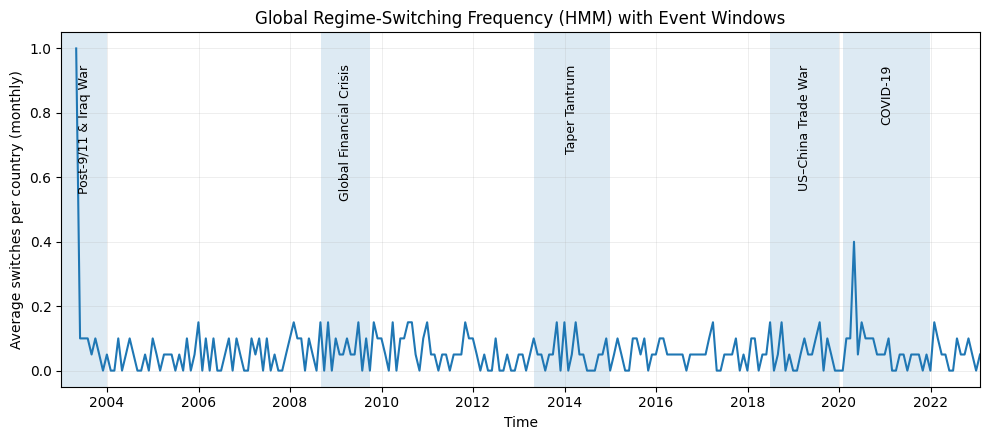

In [ ]:
## Global HMM with labels of political and economic events
import pandas as pd
import matplotlib.pyplot as plt

INPUT_CSV  = "icrg_hmm_states_monthly.csv"
OUTPUT_PNG = "hmm_regime_switching_volatility.png"

# Load and auto-detect schema
df = pd.read_csv(INPUT_CSV)

cols = {c.lower(): c for c in df.columns}  # case-insensitive map

def has_all(keys):
    return all(k in cols for k in keys)

# CASE A: segment-format -> expand to monthly
if has_all(["country", "state", "start", "end"]):
    df[cols["start"]] = pd.to_datetime(df[cols["start"]])
    df[cols["end"]]   = pd.to_datetime(df[cols["end"]])

    rows = []
    for _, r in df.iterrows():
        for d in pd.date_range(r[cols["start"]], r[cols["end"]], freq="M"):
            rows.append({"date": d,
                         "country": r[cols["country"]],
                         "state": int(r[cols["state"]])})
    dec = pd.DataFrame(rows)

# CASE B: already monthly rows
elif has_all(["date", "country", "state"]):
    dec = df.rename(columns={
        cols["date"]: "date",
        cols["country"]: "country",
        cols["state"]: "state"
    })
    dec["date"] = pd.to_datetime(dec["date"])
    dec["state"] = pd.to_numeric(dec["state"], errors="coerce").astype("Int64")
    dec = dec.dropna(subset=["state"]).astype({"state": int})

else:
    raise ValueError(
        "Unrecognized schema. Expected either "
        "[Country, State, Start, End] or [date, country, state]. "
        f"Found columns: {list(df.columns)}"
    )

# Compute monthly switching frequency across countries
dec = dec.sort_values(["country", "date"])
dec["prev_state"] = dec.groupby("country")["state"].shift(1)
dec["switch"] = (dec["state"] != dec["prev_state"]).astype(int)

agg = (dec.groupby("date")
         .agg(total_switches=("switch", "sum"),
              active_countries=("country", "nunique"))
         .reset_index())
agg["avg_switches_per_country"] = agg["total_switches"] / agg["active_countries"]

# Plot with event windows
events = [
    ("Post-9/11 & Iraq War", "2003-01-01", "2003-12-31"),
    ("Global Financial Crisis", "2008-09-01", "2009-09-30"),
    ("Taper Tantrum",          "2013-05-01", "2014-12-31"),
    ("US–China Trade War",     "2018-07-01", "2019-12-31"),
    ("COVID-19",               "2020-02-01", "2021-12-31"),
]

fig, ax = plt.subplots(figsize=(10, 4.5))
ax.plot(agg["date"], agg["avg_switches_per_country"], linewidth=1.5)
ax.set_title("Global Regime-Switching Frequency (HMM) with Event Windows")
ax.set_xlabel("Time")
ax.set_ylabel("Average switches per country (monthly)")
ax.grid(True, linewidth=0.5, alpha=0.3)
ax.margins(x=0)

ymax = float(agg["avg_switches_per_country"].max() or 1.0)
for name, start, end in events:
    xs, xe = pd.to_datetime(start), pd.to_datetime(end)
    ax.axvspan(xs, xe, alpha=0.15)
    xm = xs + (xe - xs) / 2
    ax.text(xm, ymax * 0.95, name, ha="center", va="top", rotation=90, fontsize=9)

fig.tight_layout()
fig.savefig(OUTPUT_PNG, dpi=200)
print(f"Saved: {OUTPUT_PNG}")


